In [17]:
import torch
import torch.nn as nn
from torchvision.transforms import transforms
import numpy as np
from torch.autograd import Variable
from torchvision.models import squeezenet1_1
import torch.functional as F
from io import open
import os
from PIL import Image
import pathlib
import glob

In [18]:
import os
import re
from torchvision.io import read_image, ImageReadMode
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, img_dir, labels, transform=None):
        self.img_dir = img_dir
        self.labels = labels
        self.transform = transform
        self.file_paths = []
        self.label_map = {'not_car': 0, 'car': 1}
        self.classes = labels
        
        for lab in self.labels:
            label_folder = os.path.join(str(img_dir), lab)
            file_list = [os.path.join(label_folder, file.name).replace('\\', '/') for file in os.scandir(label_folder) if file.is_file()]
            self.file_paths.extend([(file, lab) for file in file_list])
    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        img_path, label = self.file_paths[idx]
        image = read_image(img_path, mode=ImageReadMode.RGB).float() / 255.0 # Scale to [0, 1]
        if self.transform:
            image = self.transform(image)
        label_id = self.label_map[label]
        return image, label_id, img_path #image_path added extra
        
# Example usage
train_dir = 'D:/MSRSGI/Summer_Semester24/DL/Exercises/Exercise1/WorkingData/data/train'
test_dir = 'D:/MSRSGI/Summer_Semester24/DL/Exercises/Exercise1/WorkingData/data/test'
labels = ['not_car', 'car']  # Ensure this matches your directory structure

# Define the transforms
import torchvision.transforms as transforms

data_transforms = transforms.Compose([
    transforms.Resize((224, 224))
    # transforms.ToTensor()
])

train_dataset = CustomDataset(train_dir, labels, transform = data_transforms) 
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True) #takes an image not a tensor 

test_dataset = CustomDataset(test_dir, labels, transform = data_transforms) 
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=True) #takes an image not a tensor

In [19]:
#(tensor([0.4670, 0.4365, 0.4319]), tensor([0.1659, 0.1498, 0.1380]))

In [20]:
test_transforms_norm = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.ToTensor(),
    transforms.Normalize([0.4670, 0.4365, 0.4319],[0.1659, 0.1498, 0.1380])])

# dataset = datasets.ImageFolder(data_dir, transform=data_transforms)

test_dataset_norm = CustomDataset(test_dir, labels, transform = test_transforms_norm) 
len(test_dataset_norm)

1346

In [21]:
test_dataloader_norm = torch.utils.data.DataLoader(dataset=test_dataset_norm, batch_size=32, shuffle=True) #takes an image not a tensor 
len(test_dataloader_norm)

43

In [22]:
# Ensure you define the classes list based on your label map
classes = ['not-car', 'car']

In [23]:
#CNN Network

class ConvNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ConvNet, self).__init__()
        self.conv = nn.Conv2d(3, 32, kernel_size=5) #I/p = 3 different RGB Channel #O/P=32 kernels
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2, stride=2)
        self.dropout = nn.Dropout(p=0.1)
        self.fc1 = nn.Linear(32 * 110 * 110, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        # x = x.view(-1, 32 * 110 * 110) #x = x.view(-1, 32*110*110) sounds better if guaranteed the tensor has a feature size of 32*110*110
        x = x.view(x.size(0), -1) #better approach would be to use x = x.view(x.size(0), -1) to make sure the batch size does not change
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [24]:
checkpoint=torch.load('best_checkpoint.model')
model=ConvNet(num_classes=2)
model.load_state_dict(checkpoint)
model.eval()

ConvNet(
  (conv): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=387200, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)

In [25]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


Classification Report:
               precision    recall  f1-score   support

     not-car       0.93      0.99      0.96       946
         car       0.96      0.83      0.89       400

    accuracy                           0.94      1346
   macro avg       0.95      0.91      0.92      1346
weighted avg       0.94      0.94      0.94      1346

Confusion Matrix:
 [[932  14]
 [ 67 333]]


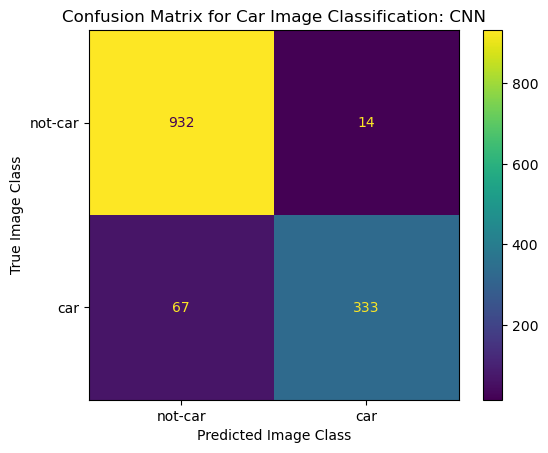

In [26]:
import os
import torch
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# # Set the model to evaluation mode
# model.eval()

# List to store results
results = []

# Disable gradient calculations
with torch.no_grad():
    # Initialize variables for predictions and true labels
    predicted_labels = []
    true_labels = [] 
    for images, labels, file_paths in test_dataloader_norm:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Calculate predicted labels
        _, predicted = torch.max(outputs.data, 1)
        
        # Update predicted labels and true labels
        predicted_labels.extend(predicted.cpu().tolist())
        true_labels.extend(labels.cpu().tolist())
        
        # Store the results for each image in the batch
        for i in range(images.size(0)):
            filename = os.path.basename(file_paths[i])
            true_label = classes[labels[i].item()]
            predicted_label = classes[predicted[i].item()]
            results.append({
                'file_path': file_paths[i].replace('\\', '/'),  # # Normalize path separators
                'true_class': true_label,
                'predicted_class': predicted_label
            })

# Calculate precision, recall, F1-score, and overall accuracy
classification_rep = classification_report(true_labels, predicted_labels, target_names=classes)
confusion_mat = confusion_matrix(true_labels, predicted_labels)

# Display the classification report and confusion matrix
print("Classification Report:\n", classification_rep)
print("Confusion Matrix:\n", confusion_mat)

# Create a DataFrame and save to CSV
df = pd.DataFrame(results)
df.to_csv('Predictions/predictions_mit_cnn.csv', index=False)

# Optionally, display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=classes)
disp.plot()
plt.xlabel("Predicted Image Class")
plt.ylabel("True Image Class")
plt.title("Confusion Matrix for Car Image Classification: CNN")
plt.savefig('Results/ConfusionMatrixCNN.pdf')
plt.show()

In [27]:
# From the confusion matrix, we can directly extract the information on the classification results and compute performance metrics of the classifier 
#not-car=0
#car=1
TN = confusion_mat[0][0] # True negative
FN = confusion_mat[1][0] # False negative
TP = confusion_mat[1][1] # True positive
FP = confusion_mat[0][1] # False positive

## We discussed these metrics of the confusion matrix in the lecture
# Probability of detection, also: sensitivity, hit rate, recall, or true positive rate
POD = TP/(TP+FN)
# Overall accuracy, also percent correct (multiply by 100 to convert to %)
ACC = (TP+TN)/(TP+FP+FN+TN)
# False alarm rate
FAR = FP/(TP+FP)
# Bias score
BS = (TP+FP)/(TP+FN)

## some additional metrics
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)

print("Probability of detection: ", round(POD,3))
print("Overall accuracy: ", round(ACC,3))
print("False alarm rate: ", round(FAR,3))
print("Bias score: ", round(BS,3))
print("False positive rate: ", round(FPR,3))

Probability of detection:  0.832
Overall accuracy:  0.94
False alarm rate:  0.04
Bias score:  0.868
False positive rate:  0.015


In [28]:
import sklearn.metrics
import matplotlib.pyplot as plt
# import seaborn as sns
fpr,tpr,thresholds=sklearn.metrics.roc_curve(true_labels, predicted_labels)

print(sklearn.metrics.auc(fpr,tpr))
print(sklearn.metrics.confusion_matrix(true_labels,np.rint(predicted_labels)))

0.908850422832981
[[932  14]
 [ 67 333]]


In [29]:
sklearn.metrics.accuracy_score(true_labels, predicted_labels) #overall accuracy

0.9398216939078752

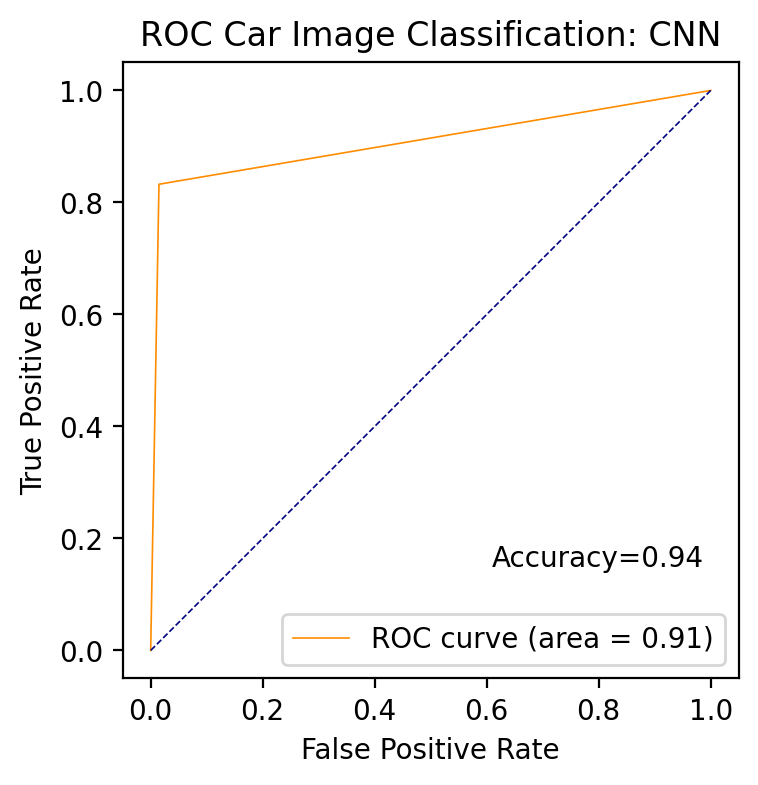

In [30]:
plt.figure(figsize=(4,4),dpi=200)
lw = 0.6
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % 0.91,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Car Image Classification: CNN")
plt.text(0.61, 0.15,"Accuracy=0.94")
plt.legend(loc="lower right")
plt.savefig('Results/rocCNN.pdf')
plt.axis('square')
plt.show()

In [31]:
df

,file_path,true_class,predicted_class
0,D:/MSRSGI/Summer_Semester24/DL/Exercises/Exerc...,car,car
1,D:/MSRSGI/Summer_Semester24/DL/Exercises/Exerc...,not-car,not-car
2,D:/MSRSGI/Summer_Semester24/DL/Exercises/Exerc...,car,not-car
3,D:/MSRSGI/Summer_Semester24/DL/Exercises/Exerc...,not-car,not-car
4,D:/MSRSGI/Summer_Semester24/DL/Exercises/Exerc...,car,car
...,...,...,...
1341,D:/MSRSGI/Summer_Semester24/DL/Exercises/Exerc...,car,car
1342,D:/MSRSGI/Summer_Semester24/DL/Exercises/Exerc...,not-car,not-car
1343,D:/MSRSGI/Summer_Semester24/DL/Exercises/Exerc...,not-car,not-car
1344,D:/MSRSGI/Summer_Semester24/DL/Exercises/Exerc...,car,car


## References:
i. https://scikit-learn.org/stable/index.html

ii. https://github.com/gaurav67890/Pytorch_Tutorials/blob/master/cnn-scratch-inference.ipynb

iii. https://github.com/ashokdahal/ExplainableAI/blob/main/TrainAndTestRevison1.ipynb

iv. Andersen, H., Exercise(WS23/24 ), Machine Learning for classification|Data Analysis in Geoscience and Remote Sensing Projects